In [46]:
import tensorflow as tf
import qriemannopt as qro
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

### Auxiliary function

In [119]:
@tf.function
def kron(A, B):
    """
    Returns kronecker product of two square matrices.
    Args:
        A: complex valued tf tensor of shape (dim1, dim1)
        B: complex valued tf tensor of shape (dim2, dim2)
    Returns:
        complex valued tf tensor of shape (dim1 * dim2, dim1 * dim2),
        kronecker product of matrices
    """
    
    dim1 = A.shape[-1]
    dim2 = B.shape[-1]
    AB = tf.transpose(tf.tensordot(A, B, axes=0), (0, 2, 1, 3))
    return tf.reshape(AB, (dim1 * dim2, dim1 * dim2))


@tf.function
def chain_kron(A):
    """
    Returns kronecer product of several matrices.
    Args:
        A: complex valued tf tensor of shape (dim1, dim2, dim3), fisrt index marks number of matrix
    Returns:
        complex valued tf tensor of shape (dim2 ** dim1, dim3 ** dim1), kronecer
        product of all matrices
    """
    
    dim = A.shape[0]
    B = A[0]
    for i in range(1, dim):
        B = kron(B, A[i])
    return B


def cnot_layer(tuple_of_pairs):
    """
    Returns layer with cnot gates ordered according input information
    Args:
        tuple_of_pairs: tuple with information about ordering of cnot gates. For example
        if input tuple is (2, 0, 1, 3), then one has cnot gate acting on sites number 2, and 0,
        a cnot gate acting on site number 1 and 3
    Returns:
        complex valued tf tensor of shape (2 ** len(tuple_of_pairs), 2 ** (tuple_of_pairs))
    """
    
    dim = int(len(tuple_of_pairs) / 2)
    cnot = tf.constant([[1, 0, 0, 0],
                        [0, 1, 0, 0],
                        [0, 0, 0, 1],
                        [0, 0, 1, 0]], dtype=tf.complex128)
    new_order = np.argsort(np.array(tuple_of_pairs))
    permut_cnot = cnot
    for _ in range(dim - 1):
        permut_cnot = kron(permut_cnot, cnot)
    permut_cnot = tf.reshape(permut_cnot, 4 * dim * (2,))
    permut_cnot = tf.transpose(permut_cnot, tuple(new_order) + tuple(new_order + 2 * dim))
    return tf.reshape(permut_cnot, (2 ** (2 * dim), 2 ** (2 * dim)))

### Random target gate, length of trained gate and initial random values for one qubit gates

In [131]:
#=====================================#
num_of_qubits = 4  # number of qubits
circuit_length = 4  # length of ciruid
#=====================================#

# state to be prepared (maximally entangled)
psi_true = tf.random.normal((2 ** int(num_of_qubits / 2),
                             2 ** int(num_of_qubits / 2),
                             2), dtype=tf.float64)
psi_true = qro.manifold.real_to_complex(psi_true)
psi_true = tf.linalg.qr(psi_true)[0]
psi_true = tf.reshape(psi_true, (-1,))
psi_true = psi_true / tf.linalg.norm(psi_true)

# initial state
psi_in = tf.constant([1] + (2 ** num_of_qubits - 1) * [0],
                     dtype=tf.complex128)

# initial one qubit gates
u = [tf.linalg.qr(qro.manifold.real_to_complex(tf.random.normal((num_of_qubits, 2, 2, 2),
                                                                dtype=tf.float64)))[0] for _ in range(circuit_length)]

u = list(map(qro.manifold.complex_to_real, u))

### Optimization loop

In [132]:
#================================#
iters = 2000 # number of iterations
lr = 0.05 # learning rate
#================================#

# optimizer
m = qro.manifold.StiefelManifold()
opt = qro.optimizers.RAdam(m, lr)

# turn one qubit gates to tf variables
varu = list(map(tf.Variable, u))

# cnot layers
cnot_layer_1 = cnot_layer((0, 1, 2, 3))
cnot_layer_2 = cnot_layer((3, 0, 1, 2))
cnot_layer_3 = cnot_layer((0, 1, 2, 3))

err = [] # will be filled by err vs iter

for _ in range(iters):
    with tf.GradientTape() as tape:
        # from real to complex
        varu_c = list(map(qro.manifold.real_to_complex, varu))

        # computing of gate
        psi_out = chain_kron(varu_c[0]) @ psi_in[:, tf.newaxis]
        psi_out = cnot_layer_1 @ psi_out
        psi_out = chain_kron(varu_c[1]) @ psi_out
        psi_out = cnot_layer_2 @ psi_out
        psi_out = chain_kron(varu_c[2]) @ psi_out
        psi_out = cnot_layer_3 @ psi_out
        psi_out = chain_kron(varu_c[3]) @ psi_out

        # loss
        loss = 1 - tf.tensordot(psi_out[:, 0], psi_true, axes=1)
        
    err.append(tf.math.sqrt(loss))
    grad = tape.gradient(loss, varu)
    opt.apply_gradients(zip(grad, varu))

### Plotting

[0] element of psi after applying curcid [-0.31541508+0.01369932j]
[0] element of psi true (-0.3154150831788033-0.013699319363497352j)


C:\Users\HYPERPC\Anaconda3\lib\site-packages\tensorflow_core\python\framework\ops.py:859: ComplexWarning: Casting complex values to real discards the imaginary part
  return float(self._numpy())
C:\Users\HYPERPC\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'err')

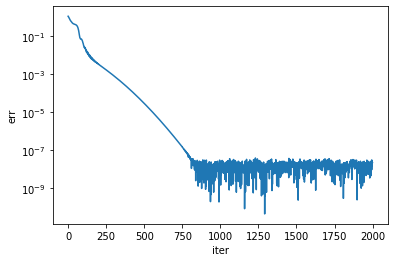

In [133]:
print('[0] element of psi after applying curcid', psi_out[0].numpy())
print('[0] element of psi true', psi_true[0].numpy())
plt.plot(err)
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')